# Comparison: stHOSVD on Original vs Log-Transformed Tensor

This notebook compares the performance of Sequentially Truncated Higher-Order Singular Value Decomposition (stHOSVD) using three different approaches:

1. **Original**: stHOSVD on original combustion tensor data (all 8 species, no transformation)
2. **Log (all species)**: stHOSVD on log-transformed tensor (all 8 species)
3. **Two-Step (subset log)**: 
   - Step 1: Log-transform and compress subset (H, O, OH, HO2, H2O2 only)
   - Step 2: Combine reconstructed subset with original H2, O2, H2O and apply stHOSVD

The goal is to evaluate whether log transformation and selective compression improve reconstruction accuracy for data with large dynamic ranges.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import json
from tqdm import tqdm

from functions_and_viz import (
    sequentially_truncated_hosvd,
    reconstruct_tensor,
    compute_error,
    compute_error_normalized_by_species,
    compute_compression_factor,
    plot_species_comparison_bar,
    plot_error_histograms,
    plot_spatial_comparison,
    create_comparison_animation,
    print_species_comparison_table
)

## 1. Load Combustion Data

In [30]:
# Download dataset
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]

# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

# Define parameters
subsample_x, subsample_y = 5, 5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)

molar_masses = {
    'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0,
    'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0
}

file_key_map = {
    'YH': 'YH filename', 'YH2': 'YH2 filename',
    'YO': 'YO filename', 'YO2': 'YO2 filename',
    'YOH': 'YOH filename', 'YH2O': 'YH2O filename',
    'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

Grid: 1600x2000, Subsampled: 320x400


In [31]:
# Load tensor data
tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]

tensor_combustion = tensor_[:, :, :, :]
print(f"Tensor shape: {tensor_combustion.shape}")
print("Data loading complete!")

100%|██████████| 200/200 [00:21<00:00,  9.21it/s]

Tensor shape: (400, 320, 8, 200)
Data loading complete!


## 2. Create Log-Transformed Tensor

In [32]:
# Create log-transformed tensor
epsilon = 1e-10
tensor_combustion_log = np.zeros_like(tensor_combustion)

for i in range(tensor_combustion.shape[2]):
    tensor_combustion_log[:, :, i, :] = np.log(np.maximum(tensor_combustion[:, :, i, :], epsilon))

print(f"Log tensor shape: {tensor_combustion_log.shape}")
print(f"Original tensor range: [{tensor_combustion.min():.6e}, {tensor_combustion.max():.6e}]")
print(f"Log tensor range: [{tensor_combustion_log.min():.6f}, {tensor_combustion_log.max():.6f}]")

Log tensor shape: (400, 320, 8, 200)
Original tensor range: [-2.330029e-07, 3.249700e-01]
Log tensor range: [-23.025851, -1.124022]


## 3. Run stHOSVD on Original Tensor

In [33]:
print("Running stHOSVD on original tensor...")

varepsilon = 0.99  # Energy retention ratio

core_st_orig, factors_st_orig, time_orig = sequentially_truncated_hosvd(
    tensor_combustion,
    varepsilon=varepsilon,
    time_it=True
)

# Reconstruct
reconstruction_st_orig = reconstruct_tensor(core_st_orig, factors_st_orig)

# Compute errors
error_st_orig = compute_error(tensor_combustion, reconstruction_st_orig)
compression_orig = compute_compression_factor(tensor_combustion, core_st_orig, factors_st_orig)

print(f"\nResults for Original Tensor:")
print(f"  Computation time: {time_orig:.2f} seconds")
print(f"  Core shape: {core_st_orig.shape}")
print(f"  Relative error: {error_st_orig:.6f}")
print(f"  Compression factor: {compression_orig:.2f}x")

Running stHOSVD on original tensor...

Results for Original Tensor:
  Computation time: 3.82 seconds
  Core shape: (93, 53, 3, 187)
  Relative error: 0.011799
  Compression factor: 71.69x


## 4. Run stHOSVD on Log-Transformed Tensor

In [34]:
print("Running stHOSVD on log-transformed tensor...")

core_st_log, factors_st_log, time_log = sequentially_truncated_hosvd(
    tensor_combustion_log,
    varepsilon=varepsilon,
    time_it=True
)

# Reconstruct in log space and transform back
reconstruction_st_log_space = reconstruct_tensor(core_st_log, factors_st_log)
reconstruction_st_log = np.exp(reconstruction_st_log_space)

# Compute errors
error_st_log = compute_error(tensor_combustion, reconstruction_st_log)
compression_log = compute_compression_factor(tensor_combustion_log, core_st_log, factors_st_log)

print(f"\nResults for Log-Transformed Tensor:")
print(f"  Computation time: {time_log:.2f} seconds")
print(f"  Core shape: {core_st_log.shape}")
print(f"  Relative error: {error_st_log:.6f}")
print(f"  Compression factor: {compression_log:.2f}x")

Running stHOSVD on log-transformed tensor...

Results for Log-Transformed Tensor:
  Computation time: 2.06 seconds
  Core shape: (84, 65, 7, 161)
  Relative error: 0.043538
  Compression factor: 32.82x


## 5. Two-Step Log Approach (Subset Log + Combined HOSVD)

### 5.1 Step 1: Log-transform subset of species (excluding H2, O2, H2O)

In [35]:
print("Two-Step Approach - Step 1: Log on subset of species...")

# Define species indices
# Species order: ['H', 'H2', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2']
# Indices:        [0,    1,    2,   3,    4,     5,     6,      7]
excluded_indices = [1, 3, 5]  # H2, O2, H2O
included_indices = [0, 2, 4, 6, 7]  # H, O, OH, HO2, H2O2

print(f"Excluded species: {[species_names[i] for i in excluded_indices]}")
print(f"Included species: {[species_names[i] for i in included_indices]}")

# Extract subset tensor (only 5 species)
tensor_subset = tensor_combustion[:, :, included_indices, :]
print(f"\nSubset tensor shape: {tensor_subset.shape}")

# Apply log transformation to subset
epsilon = 1e-10
tensor_subset_log = np.log(np.maximum(tensor_subset, epsilon))
print(f"Subset log tensor range: [{tensor_subset_log.min():.6f}, {tensor_subset_log.max():.6f}]")

# Run stHOSVD on log-transformed subset
core_subset_log, factors_subset_log, time_subset_step1 = sequentially_truncated_hosvd(
    tensor_subset_log,
    varepsilon=varepsilon,
    time_it=True
)

# Reconstruct in log space and transform back to original space
reconstruction_subset_log_space = reconstruct_tensor(core_subset_log, factors_subset_log)
reconstruction_subset = np.exp(reconstruction_subset_log_space)

print(f"\nStep 1 Results:")
print(f"  Computation time: {time_subset_step1:.2f} seconds")
print(f"  Core shape: {core_subset_log.shape}")
print(f"  Subset reconstructed shape: {reconstruction_subset.shape}")

Two-Step Approach - Step 1: Log on subset of species...
Excluded species: ['H2', 'O2', 'H2O']
Included species: ['H', 'O', 'OH', 'HO2', 'H2O2']

Subset tensor shape: (400, 320, 5, 200)
Subset log tensor range: [-23.025851, -5.305311]

Step 1 Results:
  Computation time: 0.87 seconds
  Core shape: (78, 62, 4, 159)
  Subset reconstructed shape: (400, 320, 5, 200)


### 5.2 Step 2: Combine with original H2, O2, H2O and run stHOSVD

In [36]:
print("Two-Step Approach - Step 2: Combine and run stHOSVD...")

# Create combined tensor with all 8 species in original order
# Reconstructed subset species at their original indices: [0, 2, 4, 6, 7]
# Original excluded species at indices: [1, 3, 5]
tensor_combined = np.zeros_like(tensor_combustion)

# Map reconstructed subset back to original positions
for new_idx, orig_idx in enumerate(included_indices):
    tensor_combined[:, :, orig_idx, :] = reconstruction_subset[:, :, new_idx, :]

# Add original (non-compressed) H2, O2, H2O data
for orig_idx in excluded_indices:
    tensor_combined[:, :, orig_idx, :] = tensor_combustion[:, :, orig_idx, :]

print(f"Combined tensor shape: {tensor_combined.shape}")
print(f"Combined tensor range: [{tensor_combined.min():.6e}, {tensor_combined.max():.6e}]")

# Run stHOSVD on combined tensor (NO log transformation)
core_combined, factors_combined, time_subset_step2 = sequentially_truncated_hosvd(
    tensor_combined,
    varepsilon=varepsilon,
    time_it=True
)

# Reconstruct final tensor
reconstruction_twostep = reconstruct_tensor(core_combined, factors_combined)

# Compute errors
error_twostep = compute_error(tensor_combustion, reconstruction_twostep)
compression_twostep = compute_compression_factor(tensor_combined, core_combined, factors_combined)

print(f"\nStep 2 Results:")
print(f"  Computation time: {time_subset_step2:.2f} seconds")
print(f"  Core shape: {core_combined.shape}")
print(f"  Relative error: {error_twostep:.6f}")
print(f"  Compression factor: {compression_twostep:.2f}x")

print(f"\nTwo-Step Total Time: {time_subset_step1 + time_subset_step2:.2f} seconds")

Two-Step Approach - Step 2: Combine and run stHOSVD...
Combined tensor shape: (400, 320, 8, 200)
Combined tensor range: [-2.330029e-07, 3.249700e-01]

Step 2 Results:
  Computation time: 1.41 seconds
  Core shape: (93, 53, 3, 187)
  Relative error: 0.011801
  Compression factor: 71.69x

Two-Step Total Time: 2.28 seconds


## 6. Compare All Three Approaches

In [37]:
# Compute normalized errors by species for all three approaches
overall_error_orig, per_species_errors_orig = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_st_orig, species_axis=2
)

overall_error_log, per_species_errors_log = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_st_log, species_axis=2
)

overall_error_twostep, per_species_errors_twostep = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_twostep, species_axis=2
)

# Print comparison table
print("="*90)
print("NORMALIZED ERROR BY SPECIES (Normalized by species mean)")
print("="*90)
print(f"{'Species':<10} {'Original':<20} {'Log (all)':<20} {'Two-Step':<20}")
print("-"*90)

for i, species in enumerate(species_names):
    print(f"{species:<10} {per_species_errors_orig[i]:<20.6f} "
          f"{per_species_errors_log[i]:<20.6f} {per_species_errors_twostep[i]:<20.6f}")

print("-"*90)
print(f"{'Overall':<10} {overall_error_orig:<20.6f} "
      f"{overall_error_log:<20.6f} {overall_error_twostep:<20.6f}")
print("="*90)

NORMALIZED ERROR BY SPECIES (Normalized by species mean)
Species    Original             Log (all)            Two-Step            
------------------------------------------------------------------------------------------
H          0.899075             0.132134             0.900125            
H2         0.029332             0.123239             0.029331            
O          2.995184             0.551674             2.997060            
O2         0.005729             0.040463             0.005739            
OH         2.633725             0.693181             2.635153            
H2O        0.035540             0.185101             0.035566            
HO2        2.624642             0.197758             2.624935            
H2O2       2.770058             0.142612             2.769951            
------------------------------------------------------------------------------------------
Overall    1.499161             0.258270             1.499733            


## 7. Visualizations

In [38]:
# Note: The plot_species_comparison_bar function only supports comparing two approaches.
# For three-way comparison, see the error statistics tables above.

# Uncomment to see bar plot comparing Original vs Log (all species):
# plot_species_comparison_bar(
#     per_species_errors_orig,
#     per_species_errors_log,
#     species_names,
#     overall_error_orig,
#     overall_error_log
# )

### 7.2 Error Histograms and Statistics per Species

In [39]:
# Print error statistics for all three approaches
error_orig = (tensor_combustion - reconstruction_st_orig)
error_log = (tensor_combustion - reconstruction_st_log)
error_twostep = (tensor_combustion - reconstruction_twostep)

print("\nError Statistics by Species:")
print("="*110)
print(f"{'Species':<8} | {'Original Max':<12} {'Mean':<12} | "
      f"{'Log Max':<12} {'Mean':<12} | {'Two-Step Max':<12} {'Mean':<12}")
print("-"*110)

for i in range(n_species):
    err_o = error_orig[:, :, i, :].ravel()
    err_l = error_log[:, :, i, :].ravel()
    err_t = error_twostep[:, :, i, :].ravel()
    
    print(f"{species_names[i]:<8} | {np.max(np.abs(err_o)):>12.3e} {np.mean(err_o):>12.3e} | "
          f"{np.max(np.abs(err_l)):>12.3e} {np.mean(err_l):>12.3e} | "
          f"{np.max(np.abs(err_t)):>12.3e} {np.mean(err_t):>12.3e}")
print("="*110)


Error Statistics by Species:
Species  | Original Max Mean         | Log Max      Mean         | Two-Step Max Mean        
--------------------------------------------------------------------------------------------------------------
H        |    3.710e-03   -5.999e-07 |    5.395e-04   -1.999e-07 |    3.701e-03   -4.168e-07
H2       |    5.591e-02    7.122e-09 |    8.893e-02    2.900e-05 |    5.585e-02    7.196e-09
O        |    1.726e-03    3.763e-06 |    7.015e-04   -2.850e-06 |    1.737e-03    1.206e-05
O2       |    1.939e-03   -3.161e-08 |    3.092e-03   -3.076e-05 |    1.940e-03   -3.700e-08
OH       |    2.227e-03    7.782e-06 |    1.037e-03    1.957e-05 |    2.246e-03    1.965e-06
H2O      |    4.260e-03   -3.939e-07 |    2.599e-02   -1.333e-05 |    4.262e-03   -3.924e-07
HO2      |    1.030e-05    1.996e-09 |    2.463e-06   -9.284e-10 |    1.032e-05    8.330e-10
H2O2     |    7.385e-07    3.768e-10 |    2.036e-07    5.407e-11 |    7.382e-07    1.056e-10


### 7.3 Spatial Comparison at Single Time Step

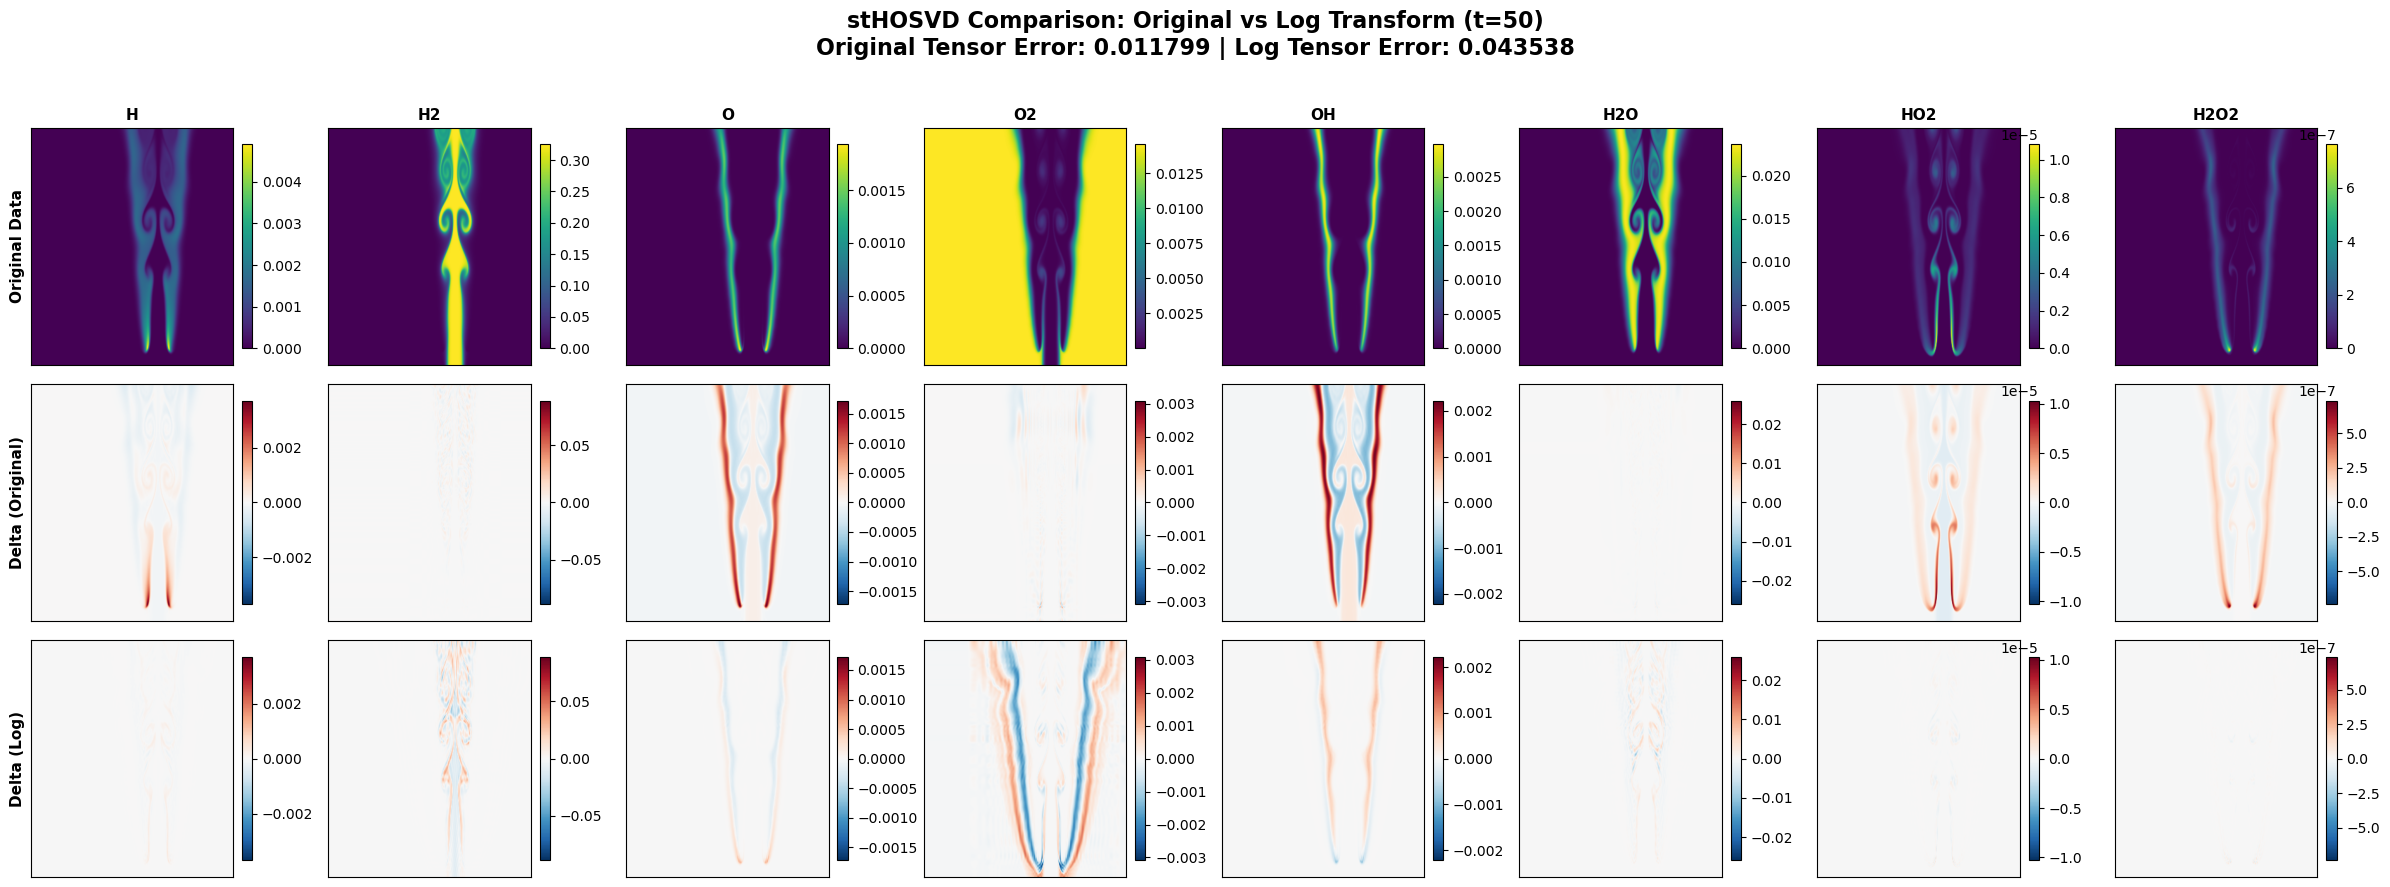


RMSE Statistics by Species (all time steps):
Species    Original RMSE             Log RMSE                  Two-Step RMSE            
------------------------------------------------------------------------------------------
H          1.898643e-04              2.790368e-05              1.900860e-04             
H2         9.220882e-04              3.874138e-03              9.220664e-04             
O          2.461596e-04              4.533944e-05              2.463138e-04             
O2         6.444028e-05              4.551088e-04              6.455105e-05             
OH         4.236163e-04              1.114934e-04              4.238459e-04             
H2O        1.090325e-04              5.678703e-04              1.091129e-04             
HO2        7.810968e-07              5.885313e-08              7.811839e-07             
H2O2       4.830190e-08              2.486744e-09              4.830002e-08             


In [40]:
# Plot spatial comparison at time step 50
time_idx = 50

plot_spatial_comparison(
    tensor_combustion,
    reconstruction_st_orig,
    reconstruction_st_log,
    species_names,
    time_idx=time_idx
)

# Print RMSE statistics per species for all three approaches
print(f"\nRMSE Statistics by Species (all time steps):")
print("="*90)
print(f"{'Species':<10} {'Original RMSE':<25} {'Log RMSE':<25} {'Two-Step RMSE':<25}")
print("-"*90)

for species_idx in range(n_species):
    orig_slice = tensor_combustion[:, :, species_idx, :]
    recon_orig_slice = reconstruction_st_orig[:, :, species_idx, :]
    recon_log_slice = reconstruction_st_log[:, :, species_idx, :]
    recon_twostep_slice = reconstruction_twostep[:, :, species_idx, :]
    
    rmse_orig = np.sqrt(np.mean((orig_slice - recon_orig_slice)**2))
    rmse_log = np.sqrt(np.mean((orig_slice - recon_log_slice)**2))
    rmse_twostep = np.sqrt(np.mean((orig_slice - recon_twostep_slice)**2))
    
    print(f"{species_names[species_idx]:<10} {rmse_orig:<25.6e} {rmse_log:<25.6e} {rmse_twostep:<25.6e}")
print("="*90)

### 7.4 Create Animation (Optional)

In [41]:
# Uncomment to create animation
# Warning: This may take several minutes

# create_comparison_animation(
#     tensor_combustion,
#     reconstruction_st_orig,
#     reconstruction_st_log,
#     species_names,
#     output_filename='stHOSVD_comparison_animation.gif',
#     fps=10
# )

## 8. Summary and Conclusions

In [42]:
print("="*90)
print("SUMMARY OF COMPARISON: THREE APPROACHES")
print("="*90)

print(f"\n{'Metric':<35} {'Original':<18} {'Log (all)':<18} {'Two-Step':<18}")
print("-"*90)

# Overall performance
print(f"{'Relative Error:':<35} {error_st_orig:<18.6f} {error_st_log:<18.6f} {error_twostep:<18.6f}")

# Normalized error
print(f"{'Normalized Error (by species):':<35} {overall_error_orig:<18.6f} "
      f"{overall_error_log:<18.6f} {overall_error_twostep:<18.6f}")

# Computation time
total_time_twostep = time_subset_step1 + time_subset_step2
print(f"{'Computation Time (s):':<35} {time_orig:<18.2f} {time_log:<18.2f} {total_time_twostep:<18.2f}")

# Compression
print(f"{'Compression Factor:':<35} {compression_orig:<18.2f} {compression_log:<18.2f} {compression_twostep:<18.2f}")

# Core sizes
print(f"{'Core Shape:':<35} {str(core_st_orig.shape):<18} "
      f"{str(core_st_log.shape):<18} {str(core_combined.shape):<18}")

print("\n" + "="*90)
print("CONCLUSION:")
print("-"*90)

# Find best method
errors = {
    'Original': error_st_orig,
    'Log (all species)': error_st_log,
    'Two-Step (log subset)': error_twostep
}

best_method = min(errors, key=errors.get)
best_error = errors[best_method]

print(f"\nBest performing method: {best_method}")
print(f"Error: {best_error:.6f}")

if best_method == 'Two-Step (log subset)':
    print("\nThe two-step approach (log on H, O, OH, HO2, H2O2 + combined HOSVD) achieves")
    print("the best reconstruction accuracy.")
    if error_st_orig > error_twostep:
        improvement = (error_st_orig - error_twostep) / error_st_orig * 100
        print(f"Improvement over original: {improvement:.1f}%")
elif best_method == 'Log (all species)':
    print("\nApplying log transformation to all species achieves the best accuracy.")
    if error_st_orig > error_st_log:
        improvement = (error_st_orig - error_st_log) / error_st_orig * 100
        print(f"Improvement over original: {improvement:.1f}%")
else:
    print("\nThe original approach (no log transformation) performs best for this dataset.")

print("="*90)

SUMMARY OF COMPARISON: THREE APPROACHES

Metric                              Original           Log (all)          Two-Step          
------------------------------------------------------------------------------------------


TypeError: unsupported format string passed to numpy.ndarray.__format__